# Introduction

The project aims to create a **Machine Learning** powered model which is capable of classifying the emotions of the text (in the form of short quotes/comments) with predefined labels of emotions.

Emotion detection, also known as sentiment analysis, is now one of the most attractive subfields of Machine Learning, especially Natural Language Processing (NLP) due to its wide applications in many aspects of modern life, such as providing emotional information to help people developing insights or making decisions. In this project, we specifically try to convey the main emotion of a comment sentence. Generally, we expect the model to be able to take the input sentence in the form of short comments and returns its major emotion(s), corresponding to one of the predefined labels.

Our approach to solving this problem is to split it into two halves:

  1.   Data Preprocessing
  2.   Model training and Result

For detail of each half, please go into the section


The dataset we use in this project is obtained from Kaggle: [EDFT Dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

Connect to Google Drive

# **Data Preprocessing**

## Importation & Data loading

Preparing necessary packages (may need to add more):

In [1]:
import numpy as np  # Work with multi-dimenional data
import pandas as pd # Work with relational data
import matplotlib.pyplot as plt # Visualize data
import seaborn as sns # Visualize data base on matplotlib
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")
# Because I hate seeing stupid warnings~

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
# Used for automatic feature extraction
from sklearn.pipeline import Pipeline
# Used for automating processes
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
# Used for spliting test and tuning hyperparameter
from sklearn.model_selection import StratifiedShuffleSplit
# Used for k-fold validiator in multi-classficiation

from sklearn.neighbors import KNeighborsClassifier
# Defining kNN
from sklearn.tree import DecisionTreeClassifier
# Defining Decision Tree
from sklearn.ensemble import RandomForestClassifier
# Defining Random Forest
from sklearn.svm import SVC
# Defining Classifier SVM
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# Defining Naive Bayes

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Used for calculating metric-related scores of the model performance, and plotting the confusion matrix

%matplotlib inline

Load data from files

In [2]:
directory = 'data/dataset/'

# This method use to extract all the file in the input list
def extract_data(files):
  data_x_raw = list()
  data_y_raw = list()
  for file in files:
    with open(directory + file) as f:
      for line in f:
        line = line.strip('\n')
        x_raw, y_raw = line.split(sep=';')

        data_x_raw.append(x_raw)
        data_y_raw.append(y_raw)

  return data_x_raw, data_y_raw

In [3]:
# Get all data

X_raw, y_raw = extract_data(['train.txt', 'val.txt', 'test.txt'])
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.2)

print("Traning data's size is:", len(X_train_raw))
print("Test data's size is:", len(X_test_raw))

Traning data's size is: 16000
Test data's size is: 4000


## Inital feature Extraction


Removing the stopword

In [4]:
file = open(file="data/stopwords/stop_words_english.txt", mode='r', encoding='UTF-8')
stopword_list = file.read().split('\n')
file.close()

Vectorize the data:

1.   Bag Of Words model (https://en.wikipedia.org/wiki/Bag-of-words_model)
2.   BoW/TF-IDF model (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)



In [5]:
# Scikit CountVectorizer:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

count_vector = CountVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow = count_vector.transform(X_train_raw)
X_test_bow = count_vector.transform(X_test_raw)
dictionary = count_vector.get_feature_names_out()

print("Shape of preprocessed training data X using BoW model is: ", X_train_bow.shape)

Shape of preprocessed training data X using BoW model is:  (16000, 83675)


In [6]:
# Scikit TF-IDF:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

tfidf_vector = TfidfVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw, X_test_raw)
X_train_tfidf = tfidf_vector.transform(X_train_raw)
X_test_tfidf = tfidf_vector.transform(X_test_raw)

print("Shape of preprocessed training data X using BoW/TF-IDF model is: ", X_train_tfidf.shape)

Shape of preprocessed training data X using BoW/TF-IDF model is:  (16000, 83675)


Cast output list to ndarray

In [7]:
y_train = np.asarray(y_train_raw)
y_test = np.asarray(y_test_raw)

*Luckily we're quite done with the abbreviations!*

Another way: Using Word2Vec to capture the semantics
(Um, we'd talk about that later, ok?)


## Initial exploratory Data Analysis (EDA)

Average length of the comment:

In [8]:
# Calculate average number of characters
sum_of_chars = sum([len(x) for x in X_train_raw])
mean_number_chars = sum_of_chars / len(X_train_raw)

# Calculate average number of words
sum_of_words = sum([len(x.split()) for x in X_train_raw])
mean_number_words = sum_of_words / len(X_train_raw)

# Print
print('The mean number of characters of each line is: %d' % mean_number_chars)
print('The mean number of words of each line is: %d' % mean_number_words)

The mean number of characters of each line is: 96
The mean number of words of each line is: 19


Statistic of output labels:

Number of labels is: 6
Labels: anger, fear, joy, love, sadness, surprise

----------------------------------------------------------------------------



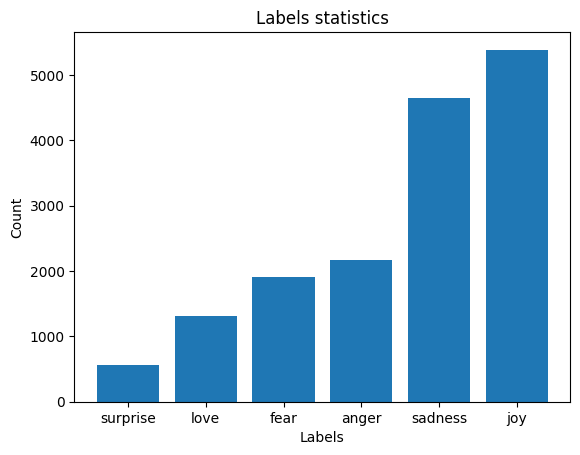

In [9]:
# Number of labels:
labels = np.unique(y_train)
print('Number of labels is: %d' % len(labels))
print('Labels: ' + ', '.join(labels))
print('\n----------------------------------------------------------------------------\n')

# Plot:
df = pd.DataFrame(
  dict(
    labels = labels,
    label_elements_count = [y_train_raw.count(label) for label in labels]
  )
)
df = df.sort_values('label_elements_count')

plt.title(label='Labels statistics')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.bar('labels', 'label_elements_count', data=df)

plt.show()

Statistics of words with the highest frequency of each label:

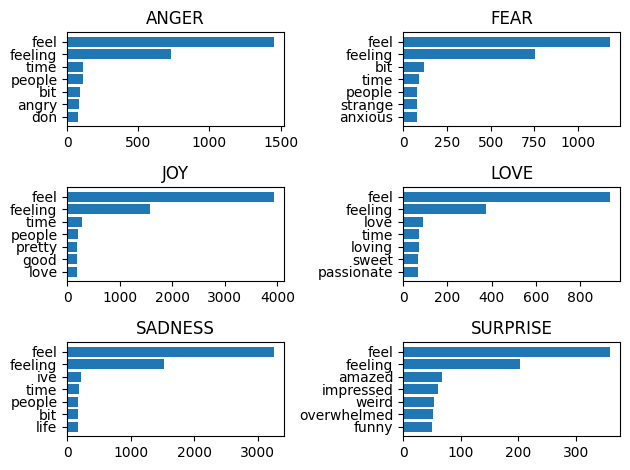

In [10]:
def show_highest_frequency_words():
  vect_arr = X_train_bow.toarray()
  vect_aggr = np.zeros(shape=(len(labels), vect_arr.shape[1]))

  for idx in range(len(vect_arr)):
    label_idx = int(np.where(labels==y_train[idx])[0][0])

    vect_aggr[label_idx] += vect_arr[idx]

  fig, axs = plt.subplots(3, 2)

  for label_idx in range(len(labels)):
    axs_x, axs_y = label_idx // 2, label_idx % 2

    plt_ref = axs[axs_x][axs_y]
    plt_ref.set_title(labels[label_idx].upper())

    x_axis, y_axis = list(), list()
    n_argmax = np.argpartition(vect_aggr[label_idx], -7)[-7:]
    n_argmax = n_argmax[np.argsort(vect_aggr[label_idx][n_argmax])]
    for i in n_argmax:
      x_axis.append(dictionary[i])
      y_axis.append(vect_aggr[label_idx][i])

    x_axis = np.asarray(x_axis)
    y_axis = np.asarray(y_axis)

    plt_ref.barh(x_axis, y_axis)

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

show_highest_frequency_words()

## Data Fixing

This part will eliminate all the words that have bad influence to our data.
All the words will be stored in a file stored in file *filtered_words.txt*

* Words appears so many times but don't contribute much (*feel*, *feeling*,...).
* Words have no mean (*aa*,*ab*,...)
* Words appears only a few

In [11]:
file = open("data/stopwords/filtered_words.txt", 'r')
filtered_words = file.read().split('\n')

new_stopwords = stopword_list + filtered_words

Create tokenize function with the help of nltk packages

In [12]:
stemmer = PorterStemmer()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in new_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

Fit the data again

In [13]:
count_vector = CountVectorizer(stop_words=new_stopwords, tokenizer=tokenize, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow = count_vector.transform(X_train_raw)
X_test_bow = count_vector.transform(X_test_raw)
dictionary = count_vector.get_feature_names_out()

tfidf_vector = TfidfVectorizer(stop_words=new_stopwords, tokenizer=tokenize, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw, X_test_raw)
X_train_tfidf = tfidf_vector.transform(X_train_raw)
X_test_tfidf = tfidf_vector.transform(X_test_raw)

In [14]:
len(dictionary)

72316

Fixing results:

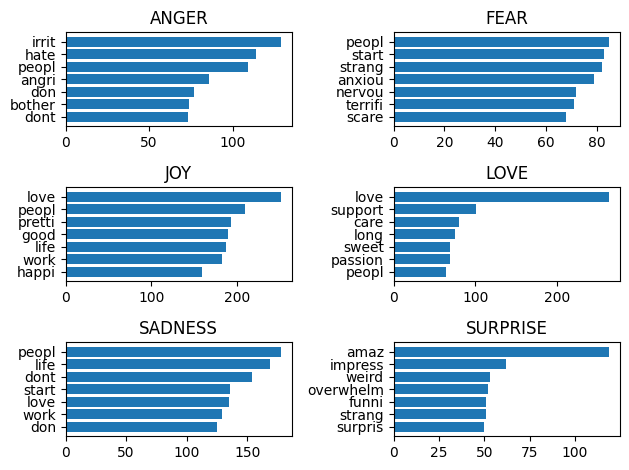

In [15]:
show_highest_frequency_words()

## Variables summary




---


**X_train_raw**, **y_train_raw**: ***list***

Raw training data which is extracted directly from files.

---


**X_test**, **y_test**: ***list***

  Raw testing data which is extracted directly from files.

---


**stopword_list**: ***list***

 List of stop words used in BoW and BoW/TF-IDF models

---


**dictionary**: ***numpy.ndarray***

 Dictionary of words which is used to vectorized the data and number of occurences.

---


**X_train_bow**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW model.

---


**X_train_tfidf**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW/TFIDF model

---


**X_test_bow**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW model.

---


**X_test_tfidf**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW/TFIDF model

---


**y_train**: ***numpy.ndarray***

 Preprocessed traning data output


---

# **Model training and result**

## Preset functions

### Summary

**evaluate_model(*model, X_train, X_test, y_train, y_test, include_training = False*)**: Evaluate score and draw confusion matrix of a model.
- ***model***: Your trained model.
- ***X_train, X_test, y_train, y_test***: The datasets used to evluate the model.
- ***include_training***: Trigger True if you want to output the training metrics. On default, false.

---

**draw_learning_curve(*model, X_train, y_train, cv = 5, train_sizes = np.linspace(0.2, 1, 5), scoring = 'accuracy'*)**: Draw the learning curve for a model.
- ***model***: Your trained model.
- ***X_train, y_train***: The datasets on which you want to draw the learning curve.
- ***cv***: Number of cross-validation folds you want to commit. On default, 5.
- ***train_sizes***: The threshold list for the learning curve to be evaluated. On default, [.2, .4, .6, .8, 1]
- ***scoring***: Scoring metric used. On default, accuracy score is used.

---

### Implementation


**evaluate_model:**

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, include_training = False):

  # [EVALUATE ON THE TRAIN]
  if include_training == True:
    # Predict from the train
    y_pred = model.predict(X_train)

    # Calculate score
    print("Score of on train are:")
    print("\t- Accuracy score: {:.2f}".format(accuracy_score(y_pred, y_train)))
    print("\t- Micro F1 score: {:.2f}".format(f1_score(y_pred, y_train, average = 'micro')))
    print("\t- Macro F1 score: {:.2f}".format(f1_score(y_pred, y_train, average = 'macro')))
    
    # Draw confusion matrix
    cm = confusion_matrix(y_pred, y_train)
    cm_plt = ConfusionMatrixDisplay(cm)
    cm_plt.plot()
    cm_plt.ax_.set_title("Confusion matrix on Train")

  # [EVALUATE ON THE TEST]
  # Predict from the test
  y_pred = model.predict(X_test)

  # Calculate score
  print("Score of on test are:")
  print("\t- Accuracy score: {:.2f}".format(accuracy_score(y_pred, y_test)))
  print("\t- Micro F1 score: {:.2f}".format(f1_score(y_pred, y_test, average = 'micro')))
  print("\t- Macro F1 score: {:.2f}".format(f1_score(y_pred, y_test, average = 'macro')))

  # Draw confusion matrix
  cm = confusion_matrix(y_pred, y_test)
  cm_plt = ConfusionMatrixDisplay(cm)
  cm_plt.plot()
  cm_plt.ax_.set_title("Confusion matrix on Test")

---

**draw_learning_curve:**

In [17]:
def draw_learning_curve(model, X_train, y_train, cv = 5, train_sizes = np.linspace(0.2, 1, 5), scoring = 'accuracy'):
  
  # Calculate list score of cross validation
  _, train_score, test_score = learning_curve(model, X_train, y_train, n_jobs = -1, cv = cv,
                                              train_sizes = train_sizes, scoring = scoring)

  # Calculate mean and standard deviation of the scores
  train_mean_score = np.mean(train_score, axis = 1)
  train_std_score = np.std(train_score, axis = 1)
  test_mean_score = np.mean(test_score, axis = 1)
  test_std_score = np.std(test_score, axis = 1)

  # Draw the plot
  plt.fill_between(train_sizes, train_mean_score - train_std_score, train_mean_score + train_std_score, alpha = 0.1, color = 'g')
  plt.fill_between(train_sizes, test_mean_score - test_std_score, test_mean_score + test_std_score, alpha = 0.1, color = 'r')

  plt.plot(train_sizes, train_mean_score, color = 'g')
  plt.plot(train_sizes, test_mean_score, color = 'r')

## K-nearest neighbors (KNN)

**DEVELOPER'S NOTE: k-NN code will be the anchor code for implementing other models. Please refer to this code as a guide when you work on other classes of models. Please refer to SleepyHunter if you ever need any more preset functions, as well as when you find a bug. Regards.**

We define the model and train it first

In [19]:
# knn_model = KNeighborsClassifier(n_neighbors = 3)
# knn_model.fit(X_train_bow, y_train)

Getting prediction on training set (without cross validation) then evaluate it!

In [20]:
# evaluate_model(knn_model, X_train_bow, X_test_bow, y_train, y_test, include_training = True)

Learning curve

In [21]:
# draw_learning_curve(knn_model, X_train_bow, y_train)

Actually I set k = 3 to beautify the record, I ran k >= 5 and it was terrible.
Now we draw the plot for a range of k-neighbors

In [22]:
# # Setting the hyperparameter range
# K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# accuracy_list = list()
# valid_accuracy_list = list()

# for k in K:
#   knn_model = KNeighborsClassifier(n_neighbors = k)
#   knn_model.fit(X_train_bow, y_train)

#   data_pred_y = knn_model.predict(X_test_bow)
#   data_valid_y = knn_model.predict(X_train_bow)

#   accuracy_list.append([k, accuracy_score(y_test, data_pred_y)])
#   valid_accuracy_list.append([k, accuracy_score(y_train, data_valid_y)])

# accuracy_list = np.asarray(accuracy_list)
# valid_accuracy_list = np.asarray(valid_accuracy_list)

# plt.plot(accuracy_list[:, 0], accuracy_list[:, 1], label = "Testing accuracy", color = 'b')
# plt.plot(valid_accuracy_list[:, 0], valid_accuracy_list[:, 1], label = "Training accuracy", color = 'r')
# plt.xlabel('Number of neighbors')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Using GridSearchCV to make a total search

In [23]:
# dict_param = {'n_neighbors': np.arange(1, 11)}
# best_knn_model = GridSearchCV(KNeighborsClassifier(), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

# best_knn_model.fit(X_train_bow, y_train)

# print("Best parameters for k_NN:", best_knn_model.best_params_)
# data_best_knn_pred_y = best_knn_model.predict(X_test_bow)
# print("Accuracy of that model:", accuracy_score(data_best_knn_pred_y, y_test))


In [24]:
# text = "I feels shitty today"
# print('fun day' in dictionary)
# vect = count_vector.transform([text])
# print(vect)
# print(count_vector.inverse_transform(vect))

# best_knn_model.predict(vect)

I'm going to do just literally the same thing for TfIdf dataset... later.

## Naive Bayes classification

## Decision Tree classification


Define the model and train it

In [18]:
DT = DecisionTreeClassifier()
DT.fit(X_train_bow, y_train)

DecisionTreeClassifier()

Getting prediction in the training set and then evaluate it

Score of on train are:
	- Accuracy score: 0.99
	- Micro F1 score: 0.99
	- Macro F1 score: 0.99
Score of on test are:
	- Accuracy score: 0.79
	- Micro F1 score: 0.79
	- Macro F1 score: 0.77


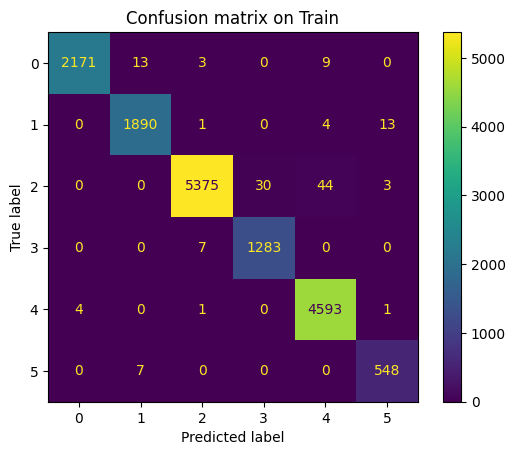

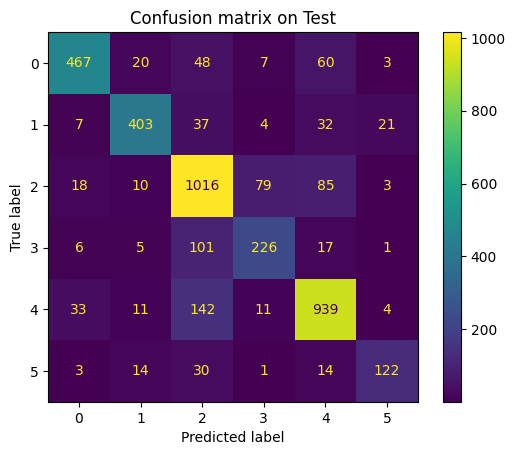

In [19]:
evaluate_model(DT, X_train_bow, X_test_bow, y_train, y_test, include_training=True)

As we can see, the model is a bit overfitting

We will draw the learning curve of the model to check the aforementioned statement

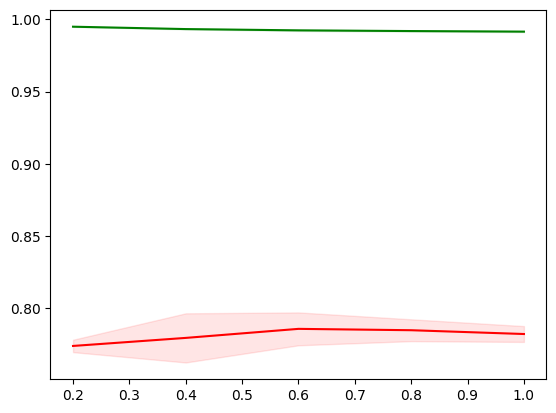

In [ ]:
draw_learning_curve(DT, X_train_bow, y_train)

Yup, this model with the default parameter is for sure overfitting

### Single tuning

#### Max_depth

In [26]:
# Setting the possible value for max depth
max_depth_list = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]

trs_list = list()
cvs_list = list()

for max_depth in max_depth_list:
    # Define model for each max_depth
    dt_model = DecisionTreeClassifier(max_depth=max_depth)
    dt_model.fit(X_train_bow, y_train)
    
    # Calculate the cross validation score
    train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
    cvs_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
    
    trs_list.append(train_score)
    cvs_list.append(cvs_score)

[Text(0, 0, '20'),
 Text(1, 0, '50'),
 Text(2, 0, '100'),
 Text(3, 0, '200'),
 Text(4, 0, '500'),
 Text(5, 0, '1000'),
 Text(6, 0, '2000'),
 Text(7, 0, '5000'),
 Text(8, 0, '10000'),
 Text(9, 0, '15000')]

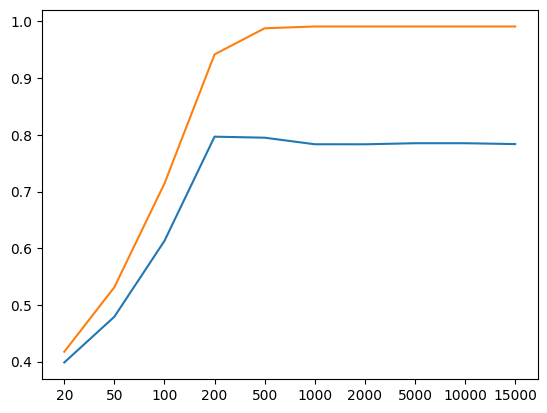

In [27]:
# Draw the plot for max depth
fig = sns.lineplot(x=list(range(len(max_depth_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(max_depth_list))), y=trs_list)
fig.set_xticks(range(len(max_depth_list)))
fig.set_xticklabels(max_depth_list)

The plot shows that max_depth around 200 would give the highest testing accuracy,

We will further examine the range 200-300 using GridSearchCV.

In [39]:
dict_param = {'max_depth': np.arange(210, 301, 3)}
dt_model = GridSearchCV(DecisionTreeClassifier(max_depth=max_depth), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

dt_model.fit(X_train_bow, y_train)

print("Best parameters for k_NN:", dt_model.best_params_)
data_dt_model_pred_y = dt_model.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_dt_model_pred_y, y_test))

Best parameters for k_NN: {'max_depth': 255}
Accuracy of that model: 0.819


We can conclude that, the best max_depth parameter is **255**

#### Min_samples_split

min_samples_split

In [20]:
# Setting the possible value for max depth
min_samples_split_list = [10, 25, 50, 100, 200, 500, 1000]

trs_list = list()
cvs_list = list()

for min_samples_split in min_samples_split_list:
    # Define model for each max_depth
    dt_model = DecisionTreeClassifier(max_depth=255, min_samples_split=min_samples_split)
    dt_model.fit(X_train_bow, y_train)
    
    # Calculate the cross validation score
    train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
    cvs_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
    
    trs_list.append(train_score)
    cvs_list.append(cvs_score)

[Text(0, 0, '10'),
 Text(1, 0, '25'),
 Text(2, 0, '50'),
 Text(3, 0, '100'),
 Text(4, 0, '200'),
 Text(5, 0, '500'),
 Text(6, 0, '1000')]

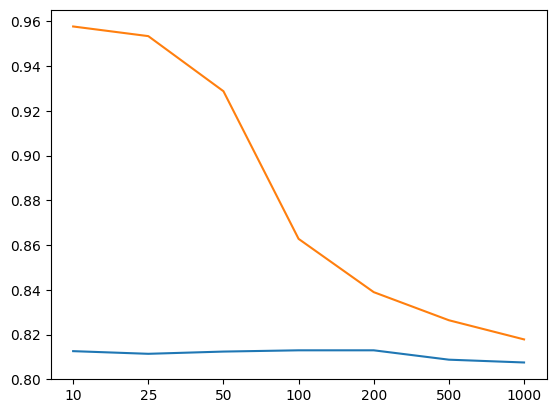

In [21]:
# Draw the plot for max depth
fig = sns.lineplot(x=list(range(len(min_samples_split_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(min_samples_split_list))), y=trs_list)
fig.set_xticks(range(len(min_samples_split_list)))
fig.set_xticklabels(min_samples_split_list)

From the plot, we can see that the best min_samples_split is close to 200.

We will further examine this range to find the best min_samples_split

In [30]:
# Setting the possible value for max depth
min_samples_split_list = [i for i in range(185, 246, 5)]

trs_list = list()
cvs_list = list()

for min_samples_split in min_samples_split_list:
    # Define model for each max_depth
    dt_model = DecisionTreeClassifier(max_depth=255, min_samples_split=min_samples_split)
    dt_model.fit(X_train_bow, y_train)
    
    # Calculate the cross validation score
    train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
    cvs_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
    
    trs_list.append(train_score)
    cvs_list.append(cvs_score)

[Text(0, 0, '185'),
 Text(1, 0, '190'),
 Text(2, 0, '195'),
 Text(3, 0, '200'),
 Text(4, 0, '205'),
 Text(5, 0, '210'),
 Text(6, 0, '215'),
 Text(7, 0, '220'),
 Text(8, 0, '225'),
 Text(9, 0, '230'),
 Text(10, 0, '235'),
 Text(11, 0, '240'),
 Text(12, 0, '245')]

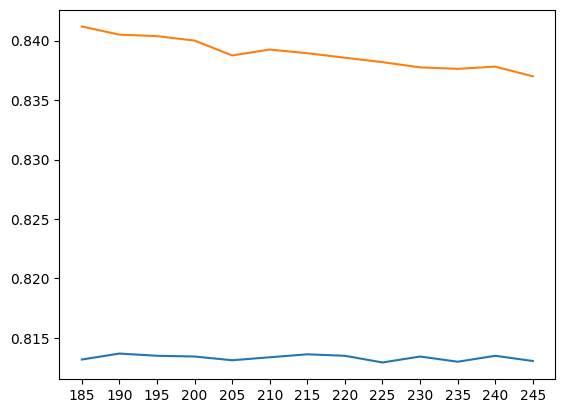

In [31]:
# Draw the plot for max depth
fig = sns.lineplot(x=list(range(len(min_samples_split_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(min_samples_split_list))), y=trs_list)
fig.set_xticks(range(len(min_samples_split_list)))
fig.set_xticklabels(min_samples_split_list)

Using GridSearchCV to find the best min_samples_split with max_depth is 255

In [34]:
dict_param = {'min_samples_split': np.arange(185, 246, 5)}
dt_model = GridSearchCV(DecisionTreeClassifier(max_depth=255), param_grid = dict_param, n_jobs = -1, cv = 8, scoring = 'accuracy')

dt_model.fit(X_train_bow, y_train)

print("Best min_samples_split for decision tree:", dt_model.best_params_)
data_dt_model_pred_y = dt_model.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_dt_model_pred_y, y_test))

Best min_samples_split for decision tree: {'min_samples_split': 190}
Accuracy of that model: 0.82475


With max_depth equals to *255*, the best min_samples_split is **190**

#### Min_samples_leaf

First, we draw the plot for the min_samples_leaf parameter

In [35]:
# Setting the min sample leaf range
min_samples_leaf_list = [1, 5, 10, 25, 50, 75, 100]
trs_list = list()
cvs_list = list()

for min_samples_leaf in min_samples_leaf_list:
  # Define model for each k
  dt_model = DecisionTreeClassifier(max_depth=255, min_samples_split=190, min_samples_leaf=min_samples_leaf)
  dt_model.fit(X_train_bow, y_train)

  # Calculate the cross validation score
  train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
  cv_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
  
  trs_list.append(train_score)
  cvs_list.append(cv_score)

[Text(0, 0, '1'),
 Text(1, 0, '5'),
 Text(2, 0, '10'),
 Text(3, 0, '25'),
 Text(4, 0, '50'),
 Text(5, 0, '75'),
 Text(6, 0, '100')]

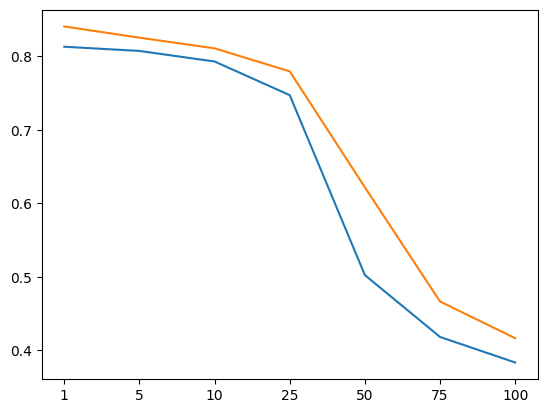

In [36]:
# Draw the plot for min_samples_leaf
fig = sns.lineplot(x=list(range(len(min_samples_leaf_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(min_samples_leaf_list))), y=trs_list)
fig.set_xticks(range(len(min_samples_leaf_list)))
fig.set_xticklabels(min_samples_leaf_list)

From the plot, we can see that the higher this parameter, the lower the accuracy for both training and testing.

Next, we use GridSearchCV to test the min_samples_leaf parameter

In [37]:
dict_param = {'min_samples_leaf': [i for i in range(1, 10)]}
best_min_sample_leaf = GridSearchCV(DecisionTreeClassifier(max_depth=255, min_samples_split=190), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

best_min_sample_leaf.fit(X_train_bow, y_train)

print("Best min sample leaf parameter for decision tree:", best_min_sample_leaf.best_params_)
data_best_min_sample_leaf_y = best_min_sample_leaf.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_best_min_sample_leaf_y, y_test))

Best min sample leaf parameter for decision tree: {'min_samples_leaf': 1}
Accuracy of that model: 0.8255


We can conclude that the best min_samples_leaf parameter is 1? *Will need more tests*

#### Max_leaf_nodes

In [42]:
# Setting the max_leaf_nodes range
max_leaf_nodes_list = [100, 250, 500, 1000, 2000]
trs_list = list()
cvs_list = list()

for max_leaf_nodes in max_leaf_nodes_list:
  # Define model for each k
  dt_model = DecisionTreeClassifier(max_depth=255, min_samples_split=190, min_samples_leaf=1, max_leaf_nodes=max_leaf_nodes)
  dt_model.fit(X_train_bow, y_train)

  # Calculate the cross validation score
  train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
  cv_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
  
  trs_list.append(train_score)
  cvs_list.append(cv_score)

[Text(0, 0, '100'),
 Text(1, 0, '250'),
 Text(2, 0, '500'),
 Text(3, 0, '1000'),
 Text(4, 0, '2000')]

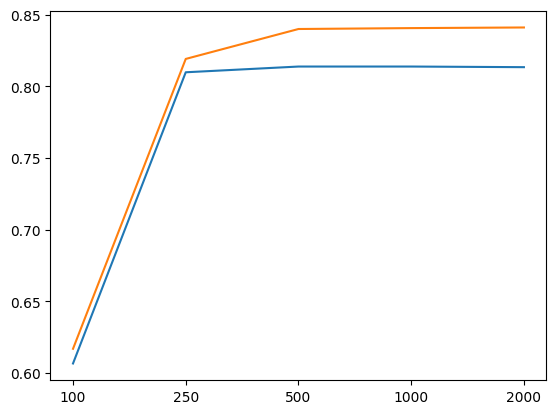

In [43]:
# Draw the plot for max_leaf_nodes
fig = sns.lineplot(x=list(range(len(max_leaf_nodes_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(max_leaf_nodes_list))), y=trs_list)
fig.set_xticks(range(len(max_leaf_nodes_list)))
fig.set_xticklabels(max_leaf_nodes_list)

In [44]:
# Setting the max_leaf_nodes range
max_leaf_nodes_list = [i for i in range(170, 271, 10)]
trs_list = list()
cvs_list = list()

for max_leaf_nodes in max_leaf_nodes_list:
  # Define model for each k
  dt_model = DecisionTreeClassifier(max_depth=255, min_samples_split=190, min_samples_leaf=1, max_leaf_nodes=max_leaf_nodes)
  dt_model.fit(X_train_bow, y_train)

  # Calculate the cross validation score
  train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
  cv_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))
  
  trs_list.append(train_score)
  cvs_list.append(cv_score)

# Draw the plot for max_leaf_nodes
fig = sns.lineplot(x=list(range(len(max_leaf_nodes_list))), y=cvs_list)
fig = sns.lineplot(x=list(range(len(max_leaf_nodes_list))), y=trs_list)
fig.set_xticks(range(len(max_leaf_nodes_list)))
fig.set_xticklabels(max_leaf_nodes_list)

#### Criterion

There are 2 criteria for Decision Tree in Scikit-learn: *gini* and *entropy*

In [38]:
criteria = ['gini', 'entropy']

trs_list = list()
cvs_list = list()

for criterion in criteria:
    # Define model for each criterion
    dt_model = DecisionTreeClassifier(criterion=criterion, max_depth=255, min_samples_split=190, min_samples_leaf=1)
    dt_model.fit(X_train_bow, y_train)
    
    # Calculate cross validation score
    train_score = accuracy_score(y_train, dt_model.predict(X_train_bow))
    cv_score = np.mean(cross_val_score(dt_model, X_train_bow, y_train, cv=5, n_jobs=-1))

    trs_list.append(train_score)
    cvs_list.append(cv_score)

  criteria  train_score  cross_validation_score
0     gini     0.839750                0.813438
1  entropy     0.828875                0.805813


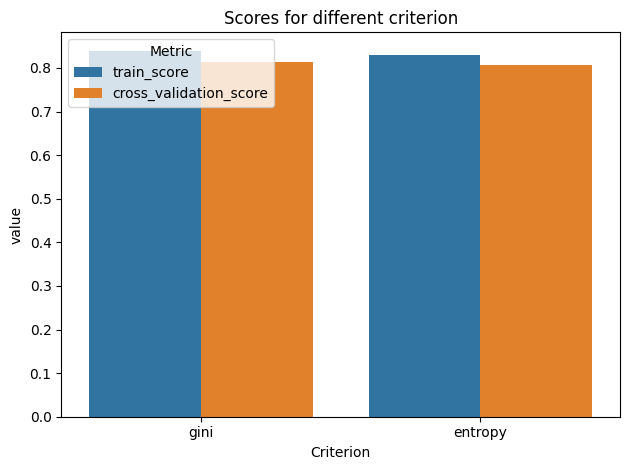

In [39]:
df = pd.DataFrame(
    dict(
        criteria = criteria,
        train_score = trs_list,
        cross_validation_score = cvs_list
    )
)
melted_df = df.melt(id_vars='criteria', var_name='metric', value_name='value')
print(df)
sns.barplot(data=melted_df, x='criteria', y='value', hue='metric')
plt.title('Scores for different criterion')
plt.xlabel('Criterion')
plt.legend(title='Metric', loc=2)
plt.tight_layout()

Through all the tests, it seems that *gini* gives the best result among the 2 criteria, although the difference is unremarkable

## Random Forest

In [32]:
# RF = RandomForestClassifier()
# RF.fit(X_train_bow, y_train)

# **Conclusion**